In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) # display all columns

In [2]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier


/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col, size = 8 )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

In [4]:
def check_null(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
    stats = pd.concat([total, percent], axis=1, keys=['Total_Null', 'Percent_Null'])
    return stats

In [5]:
data = pd.read_csv("../input/data.csv")

data.set_index('shot_id', inplace=True)
data["action_type"] = data["action_type"].astype('object')
data["combined_shot_type"] = data["combined_shot_type"].astype('category')
data["game_event_id"] = data["game_event_id"].astype('category')
data["game_id"] = data["game_id"].astype('category')
data["period"] = data["period"].astype('object')
data["playoffs"] = data["playoffs"].astype('category')
data["season"] = data["season"].astype('category')
data["shot_made_flag"] = data["shot_made_flag"].astype('category')
data["shot_type"] = data["shot_type"].astype('category')
data["team_id"] = data["team_id"].astype('category')

In [6]:
data.shape

(30697, 24)

In [7]:
data.head(20)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
2,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
3,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
4,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
5,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
6,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,0,2000-01,32,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
7,Layup Shot,Layup,251,20000012,34.0443,0,0,-118.2698,8,3,0,2000-01,52,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
8,Jump Shot,Jump Shot,254,20000012,34.0163,1,28,-118.2688,8,3,0,2000-01,5,2,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
9,Jump Shot,Jump Shot,265,20000012,33.9363,-65,108,-118.3348,6,3,0,2000-01,12,12,1.0,2PT Field Goal,Left Side(L),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30697 entries, 1 to 30697
Data columns (total 24 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null category
game_event_id         30697 non-null category
game_id               30697 non-null category
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null object
playoffs              30697 non-null category
season                30697 non-null category
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null category
shot_type             30697 non-null category
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null categor

In [9]:
data.describe(include=['number'])

,lat,loc_x,loc_y,lon,minutes_remaining,seconds_remaining,shot_distance
count,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000
mean,33.953192,7.110499,91.107535,-118.262690,4.885624,28.365085,13.437437
std,0.087791,110.124578,87.791361,0.110125,3.449897,17.478949,9.374189
min,33.253300,-250.000000,-44.000000,-118.519800,0.000000,0.000000,0.000000
25%,33.884300,-68.000000,4.000000,-118.337800,2.000000,13.000000,5.000000
50%,33.970300,0.000000,74.000000,-118.269800,5.000000,28.000000,15.000000
75%,34.040300,95.000000,160.000000,-118.174800,8.000000,43.000000,21.000000
max,34.088300,248.000000,791.000000,-118.021800,11.000000,59.000000,79.000000


In [10]:
data.describe(include=['object', 'category'])

,action_type,combined_shot_type,game_event_id,game_id,period,playoffs,season,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent
count,30697,30697,30697,30697,30697,30697,30697,25697.0,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,57,6,620,1559,7,2,20,2.0,2,6,7,5,1,1,1559,74,33
top,Jump Shot,Jump Shot,2,21501228,3,0,2005-06,0.0,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,1610612747,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,18880,23485,132,50,8296,26198,2318,14232.0,24271,13455,12625,9398,30697,30697,50,1020,1978


In [11]:
check_null(data)

,Total_Null,Percent_Null
shot_made_flag,5000,0.162882
opponent,0,0.000000
playoffs,0,0.000000
combined_shot_type,0,0.000000
game_event_id,0,0.000000
game_id,0,0.000000
lat,0,0.000000
loc_x,0,0.000000
loc_y,0,0.000000
lon,0,0.000000


## Data Visualization

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


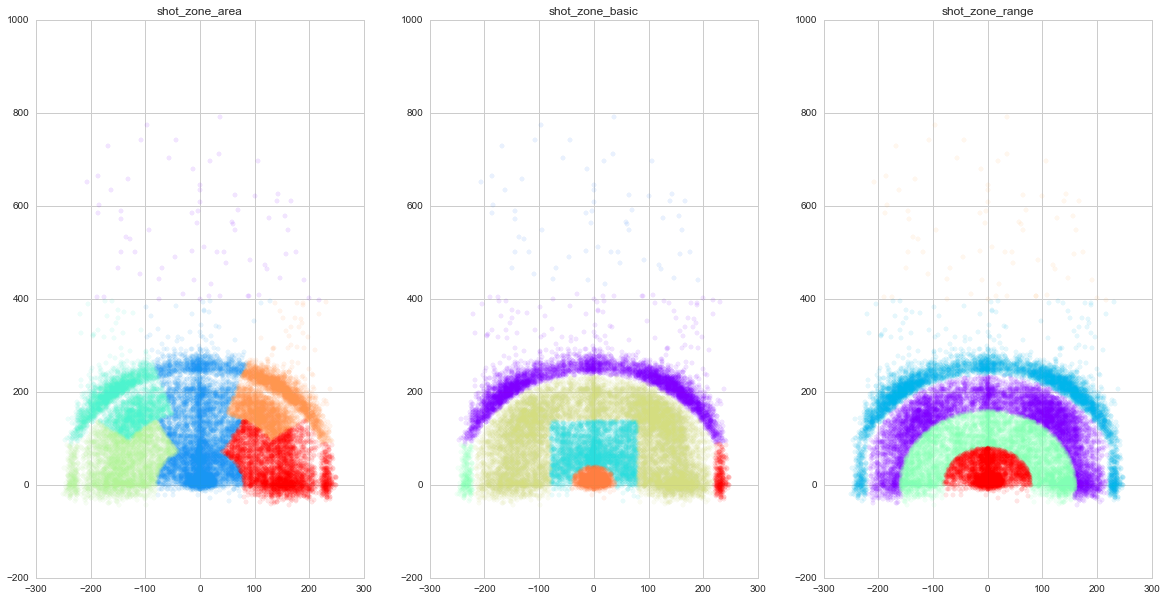

In [12]:
import matplotlib.cm as cm
plt.figure(figsize=(20,10))
nona = data.loc[pd.notnull(data.shot_made_flag)]
def scatter_plot_by_category(feat):
    alpha = 0.1
    gs = nona.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)

# shot_zone_area
plt.subplot(131)
scatter_plot_by_category('shot_zone_area')
plt.title('shot_zone_area')

# shot_zone_basic
plt.subplot(132)
scatter_plot_by_category('shot_zone_basic')
plt.title('shot_zone_basic')

# shot_zone_range
plt.subplot(133)
scatter_plot_by_category('shot_zone_range')
plt.title('shot_zone_range')

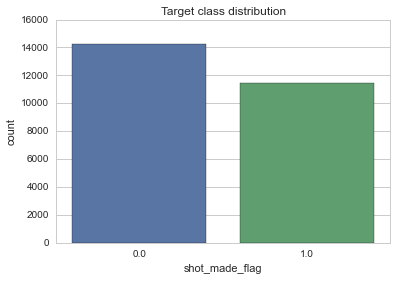

In [13]:
ax = plt.axes()
sns.countplot(x='shot_made_flag', data=data, ax=ax);
ax.set_title('Target class distribution')
plt.show()

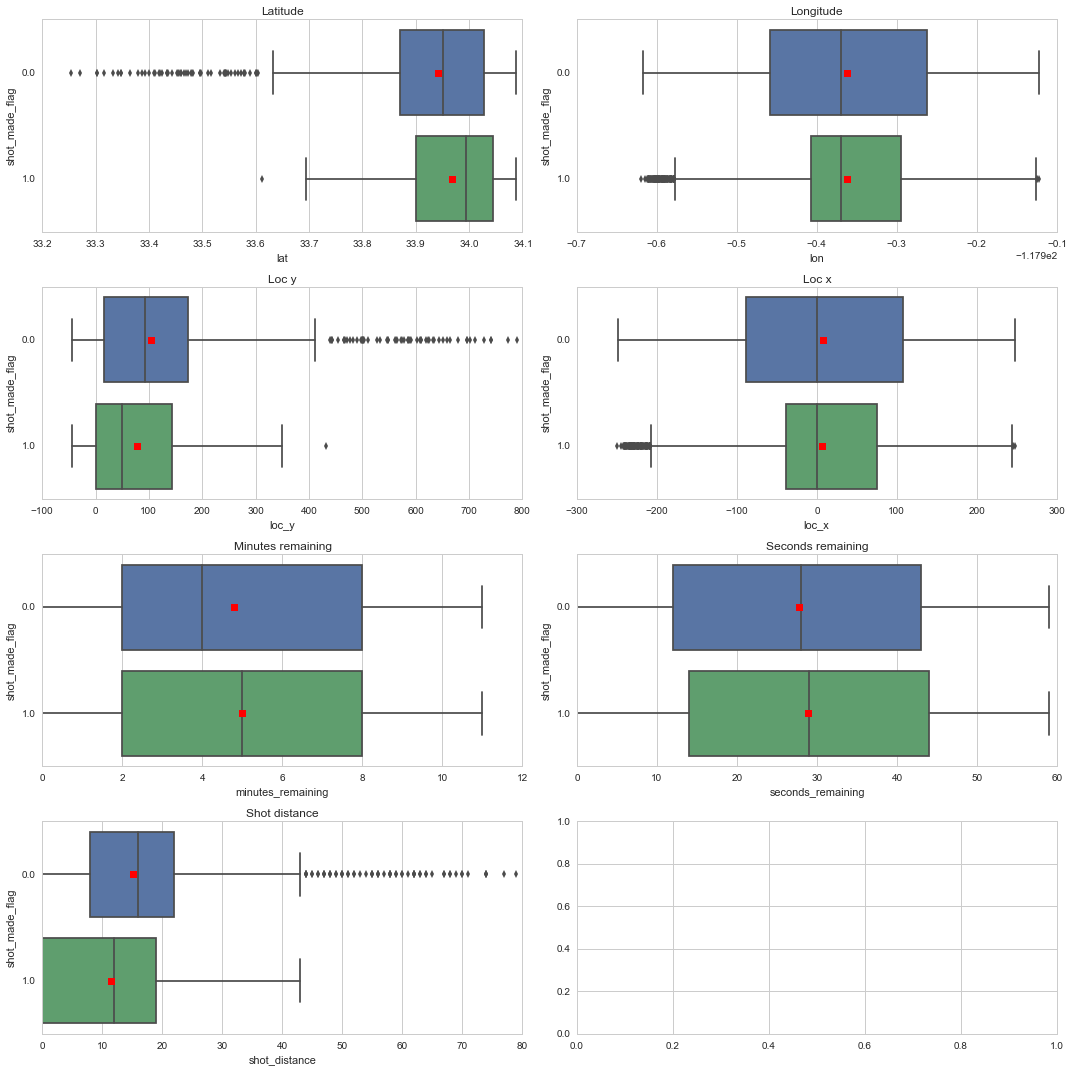

In [14]:
f, axarr = plt.subplots(4, 2, figsize=(15, 15))

sns.boxplot(x='lat', y='shot_made_flag', data=data, showmeans=True, ax=axarr[0,0])
sns.boxplot(x='lon', y='shot_made_flag', data=data, showmeans=True, ax=axarr[0, 1])
sns.boxplot(x='loc_y', y='shot_made_flag', data=data, showmeans=True, ax=axarr[1, 0])
sns.boxplot(x='loc_x', y='shot_made_flag', data=data, showmeans=True, ax=axarr[1, 1])
sns.boxplot(x='minutes_remaining', y='shot_made_flag', showmeans=True, data=data, ax=axarr[2, 0])
sns.boxplot(x='seconds_remaining', y='shot_made_flag', showmeans=True, data=data, ax=axarr[2, 1])
sns.boxplot(x='shot_distance', y='shot_made_flag', data=data, showmeans=True, ax=axarr[3, 0])

axarr[0, 0].set_title('Latitude')
axarr[0, 1].set_title('Longitude')
axarr[1, 0].set_title('Loc y')
axarr[1, 1].set_title('Loc x')
axarr[2, 0].set_title('Minutes remaining')
axarr[2, 1].set_title('Seconds remaining')
axarr[3, 0].set_title('Shot distance')

plt.tight_layout()
plt.show()

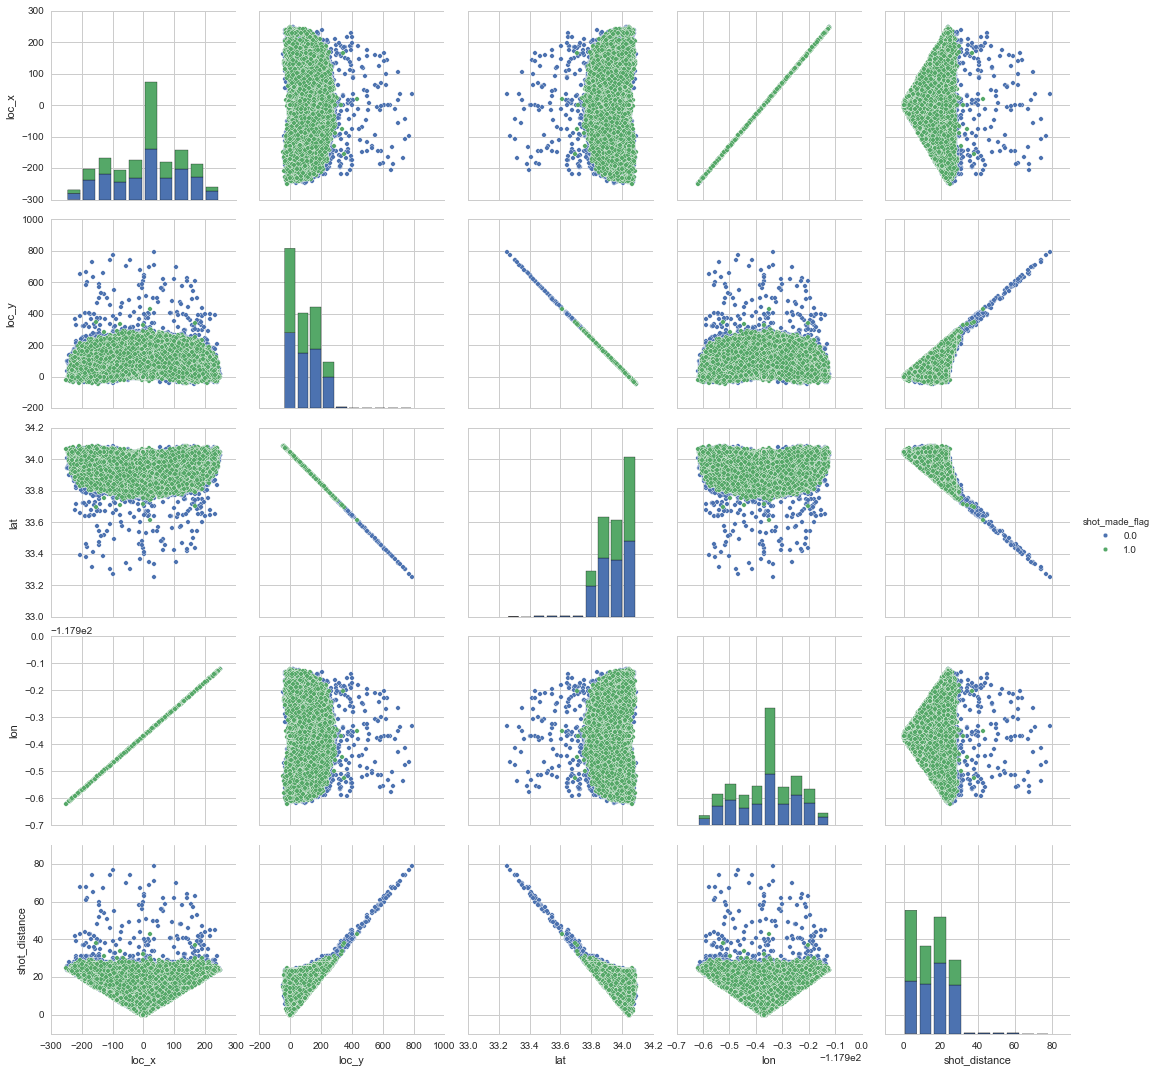

In [15]:
sns.pairplot(data, vars=['loc_x', 'loc_y', 'lat', 'lon', 'shot_distance'], hue='shot_made_flag', size=3)
plt.show()

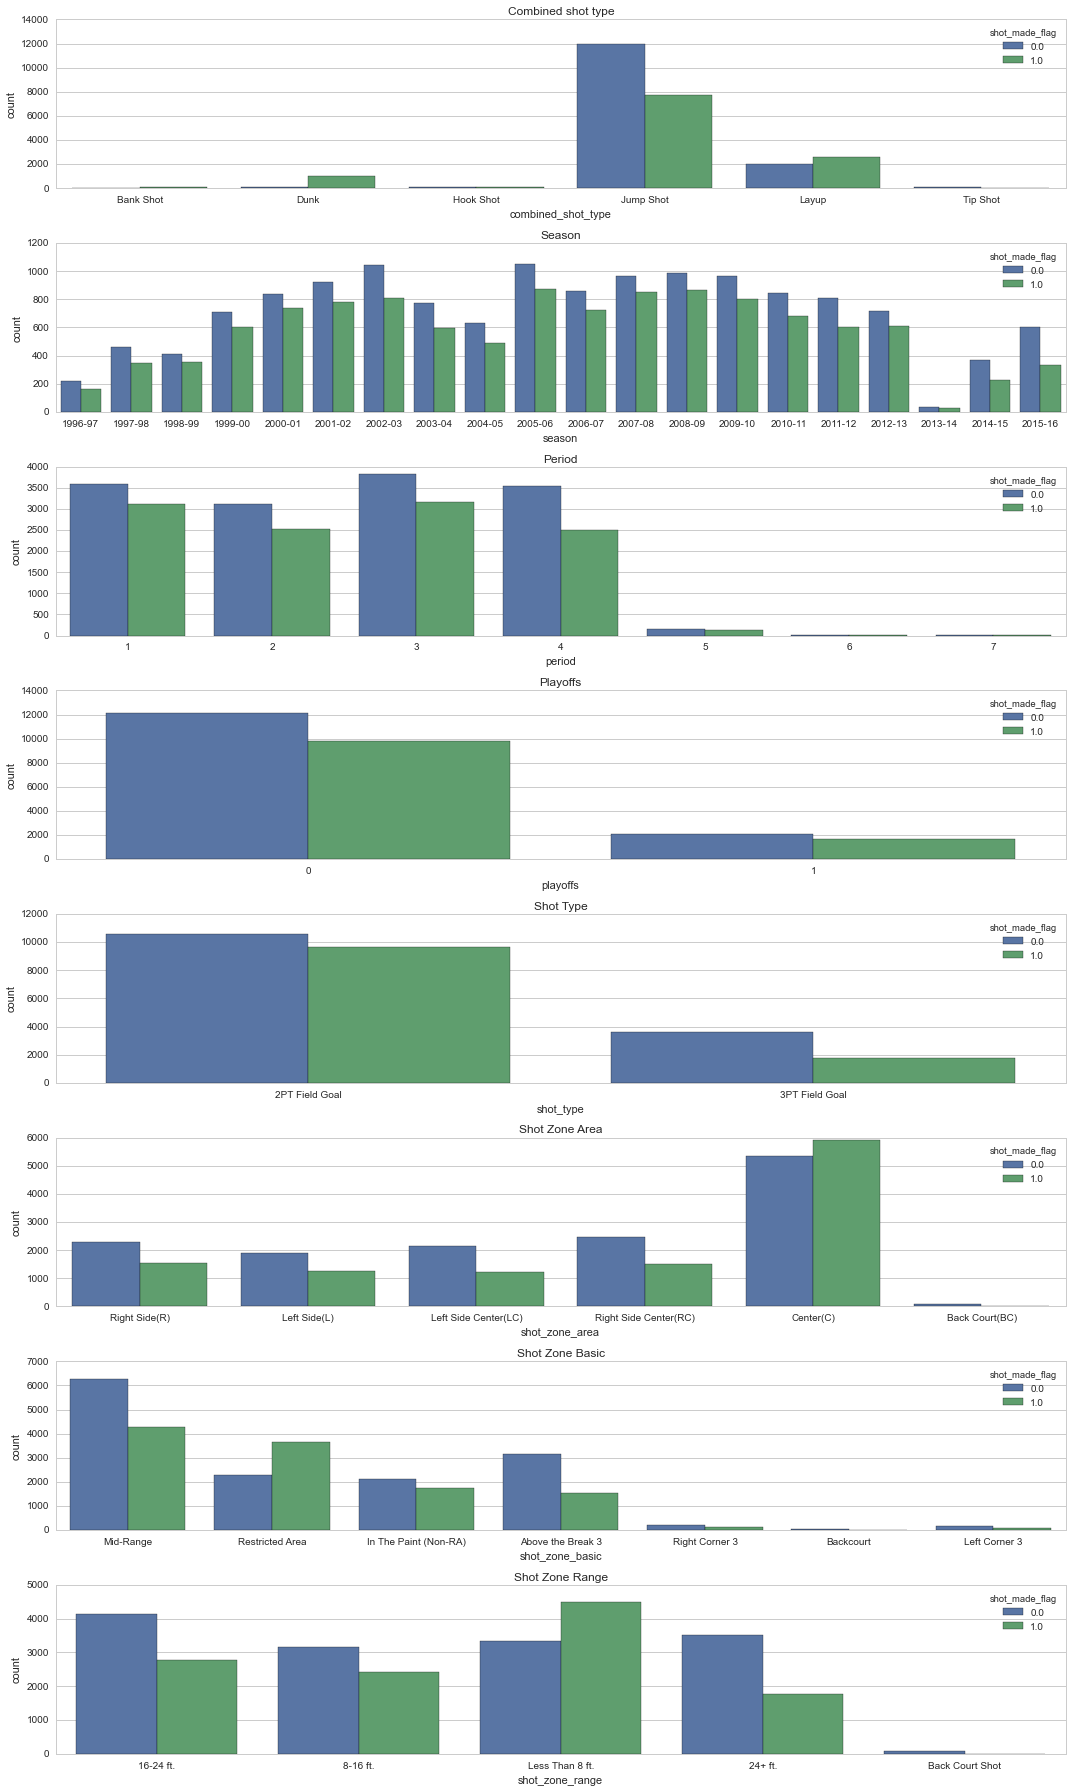

In [16]:
f, axarr = plt.subplots(8, figsize=(15, 25))

sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=data, ax=axarr[0])
sns.countplot(x="season", hue="shot_made_flag", data=data, ax=axarr[1])
sns.countplot(x="period", hue="shot_made_flag", data=data, ax=axarr[2])
sns.countplot(x="playoffs", hue="shot_made_flag", data=data, ax=axarr[3])
sns.countplot(x="shot_type", hue="shot_made_flag", data=data, ax=axarr[4])
sns.countplot(x="shot_zone_area", hue="shot_made_flag", data=data, ax=axarr[5])
sns.countplot(x="shot_zone_basic", hue="shot_made_flag", data=data, ax=axarr[6])
sns.countplot(x="shot_zone_range", hue="shot_made_flag", data=data, ax=axarr[7])

axarr[0].set_title('Combined shot type')
axarr[1].set_title('Season')
axarr[2].set_title('Period')
axarr[3].set_title('Playoffs')
axarr[4].set_title('Shot Type')
axarr[5].set_title('Shot Zone Area')
axarr[6].set_title('Shot Zone Basic')
axarr[7].set_title('Shot Zone Range')

plt.tight_layout()
plt.show()

In [17]:
import math
data["dist"] = np.sqrt(data["loc_x"] * data["loc_x"] + data["loc_y"]*data["loc_y"])
data["angle"] = np.arctan2(data["loc_y"], data["loc_x"]) * 180 / np.pi

data.loc[(data["period"] > 4), "ot"] = 1
data.loc[(data["period"] <= 4, "ot")] = 0

In [18]:
data.columns

Index([u'action_type', u'combined_shot_type', u'game_event_id', u'game_id',
       u'lat', u'loc_x', u'loc_y', u'lon', u'minutes_remaining', u'period',
       u'playoffs', u'season', u'seconds_remaining', u'shot_distance',
       u'shot_made_flag', u'shot_type', u'shot_zone_area', u'shot_zone_basic',
       u'shot_zone_range', u'team_id', u'team_name', u'game_date', u'matchup',
       u'opponent', u'dist', u'angle', u'ot'],
      dtype='object')

In [19]:
game_stats = data.groupby(["game_id"]).agg({"shot_made_flag": "count"}).rename(columns={"shot_made_flag": "game_cnt"})
game_stats

,game_cnt
game_id,
20000012,9
20000019,19
20000047,12
20000049,11
20000058,13
20000068,26
20000098,25
20000108,16
20000124,21


In [20]:
period_stats = data.groupby(["game_id", "period"]).agg({"shot_made_flag": "count"}).rename(columns={"shot_made_flag": "period_cnt"})

In [21]:
temp = data.join(game_stats, on="game_id", lsuffix="_shot", rsuffix = "_game_cnt")
input_data = temp.join(period_stats, on = ["game_id", "period"], rsuffix = "_period_cnt")

In [22]:
unknown_mask = input_data['shot_made_flag'].isnull()

In [23]:
data_cl = input_data.copy() # create a copy of data frame
target = data_cl['shot_made_flag'].copy()

# Remove some columns
data_cl.drop('team_id', axis=1, inplace=True) # Always one number
data_cl.drop('lat', axis=1, inplace=True) # Correlated with loc_x
data_cl.drop('lon', axis=1, inplace=True) # Correlated with loc_y
data_cl.drop('game_id', axis=1, inplace=True) # Independent
data_cl.drop('game_event_id', axis=1, inplace=True) # Independent
data_cl.drop('team_name', axis=1, inplace=True) # Always LA Lakers
data_cl.drop('shot_made_flag', axis=1, inplace=True)

In [24]:
def detect_outliers(series, whis=1.5):
    q75, q25 = np.percentile(series, [75 ,25])
    iqr = q75 - q25
    return ~((series - series.median()).abs() <= (whis * iqr))

In [25]:
# Remaining time
data_cl['seconds_from_period_end'] = 60 * data_cl['minutes_remaining'] + data_cl['seconds_remaining']
data_cl['last_5_sec_in_period'] = data_cl['seconds_from_period_end'] < 5

data_cl.drop('minutes_remaining', axis=1, inplace=True)
data_cl.drop('seconds_remaining', axis=1, inplace=True)
data_cl.drop('seconds_from_period_end', axis=1, inplace=True)

## Matchup - (away/home)
data_cl['home_play'] = data_cl['matchup'].str.contains('vs').astype('int')
data_cl.drop('matchup', axis=1, inplace=True)

# Game date
data_cl['game_date'] = pd.to_datetime(data_cl['game_date'])
data_cl['game_year'] = data_cl['game_date'].dt.year.astype('category')
data_cl['game_month'] = data_cl['game_date'].dt.month.astype('category')
data_cl["game_day"] = data_cl["game_date"].dt.dayofweek.astype('category')
data_cl.drop('game_date', axis=1, inplace=True)

# Loc_x, and loc_y binning
data_cl['loc_x'] = pd.cut(data_cl['loc_x'], 25)
data_cl['loc_y'] = pd.cut(data_cl['loc_y'], 25)

# Replace 20 least common action types with value 'Other'
rare_action_types = data_cl['action_type'].value_counts().sort_values().index.values[:20]
data_cl.loc[data_cl['action_type'].isin(rare_action_types), 'action_type'] = 'Other'

In [26]:
data_cl

,action_type,combined_shot_type,loc_x,loc_y,period,playoffs,season,shot_distance,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,dist,angle,ot,game_cnt,period_cnt,last_5_sec_in_period,home_play,game_year,game_month,game_day
shot_id,,,,,,,,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,"(148.4, 168.32]","(56.2, 89.6]",1,0,2000-01,18,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,POR,181.859836,23.322697,0.0,9,3,False,0,2000,10,1
2,Jump Shot,Jump Shot,"(-170.32, -150.4]","(-10.6, 22.8]",1,0,2000-01,15,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,POR,157.000000,180.000000,0.0,9,3,False,0,2000,10,1
3,Jump Shot,Jump Shot,"(-110.56, -90.64]","(123, 156.4]",1,0,2000-01,16,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,POR,168.600119,126.801931,0.0,9,3,False,0,2000,10,1
4,Jump Shot,Jump Shot,"(128.48, 148.4]","(156.4, 189.8]",1,0,2000-01,22,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,POR,222.865430,51.741697,0.0,9,3,False,0,2000,10,1
5,Driving Dunk Shot,Dunk,"(-10.96, 8.96]","(-10.6, 22.8]",2,0,2000-01,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,POR,0.000000,0.000000,0.0,9,1,False,0,2000,10,1
6,Jump Shot,Jump Shot,"(-150.4, -130.48]","(-44.835, -10.6]",3,0,2000-01,14,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,POR,145.416643,-175.661733,0.0,9,5,False,0,2000,10,1
7,Layup Shot,Layup,"(-10.96, 8.96]","(-10.6, 22.8]",3,0,2000-01,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,POR,0.000000,0.000000,0.0,9,5,False,0,2000,10,1
8,Jump Shot,Jump Shot,"(-10.96, 8.96]","(22.8, 56.2]",3,0,2000-01,2,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,POR,28.017851,87.954592,0.0,9,5,False,0,2000,10,1
9,Jump Shot,Jump Shot,"(-70.72, -50.8]","(89.6, 123]",3,0,2000-01,12,2PT Field Goal,Left Side(L),In The Paint (Non-RA),8-16 ft.,POR,126.051577,121.041710,0.0,9,5,False,0,2000,10,1


In [27]:
categorial_cols = [
    'action_type', 'combined_shot_type', 'period', 'season', 'shot_type',
    'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'game_year',
    'game_month', 'game_day', 'opponent', 'loc_x', 'loc_y']

for cc in categorial_cols:
    dummies = pd.get_dummies(data_cl[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    data_cl.drop(cc, axis=1, inplace=True)
    data_cl = data_cl.join(dummies)

In [28]:
# Separate dataset for validation
data_submit = data_cl[unknown_mask]

# Separate dataset for training
X = data_cl[~unknown_mask]
y = target[~unknown_mask]

In [29]:
train = data_cl.loc[(pd.notnull(input_data["shot_made_flag"]))]
test = data_cl.loc[(pd.isnull(input_data["shot_made_flag"]))]

In [30]:
data_cl.shape

(30697, 220)

In [31]:
threshold = 0.90
vt = VarianceThreshold().fit(X)

# Find feature names
feat_var_threshold = data_cl.columns[vt.variances_ > threshold * (1-threshold)]
feat_var_threshold

Index([u'playoffs', u'shot_distance', u'dist', u'angle', u'game_cnt',
       u'period_cnt', u'home_play', u'action_type#Jump Shot',
       u'combined_shot_type#Jump Shot', u'combined_shot_type#Layup',
       u'period#1', u'period#2', u'period#3', u'period#4',
       u'shot_type#2PT Field Goal', u'shot_type#3PT Field Goal',
       u'shot_zone_area#Center(C)', u'shot_zone_area#Left Side Center(LC)',
       u'shot_zone_area#Left Side(L)', u'shot_zone_area#Right Side Center(RC)',
       u'shot_zone_area#Right Side(R)', u'shot_zone_basic#Above the Break 3',
       u'shot_zone_basic#In The Paint (Non-RA)', u'shot_zone_basic#Mid-Range',
       u'shot_zone_basic#Restricted Area', u'shot_zone_range#16-24 ft.',
       u'shot_zone_range#24+ ft.', u'shot_zone_range#8-16 ft.',
       u'shot_zone_range#Less Than 8 ft.', u'game_month#1', u'game_month#2',
       u'game_month#3', u'game_month#4', u'game_month#11', u'game_month#12',
       u'game_day#1', u'game_day#2', u'game_day#4', u'game_day#6',
    

## Feature Selection

In [32]:
model = RandomForestClassifier()
model.fit(X, y)

feature_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["importance"])
feat_imp_20 = feature_imp.sort_values("importance", ascending=False).head(20).index
feat_imp_20

Index([u'dist', u'angle', u'game_cnt', u'period_cnt', u'action_type#Jump Shot',
       u'shot_distance', u'home_play', u'combined_shot_type#Dunk', u'period#3',
       u'period#2', u'period#1', u'period#4', u'action_type#Layup Shot',
       u'game_day#6', u'game_day#4', u'game_month#1', u'game_day#2',
       u'game_day#1', u'game_month#3', u'action_type#Driving Layup Shot'],
      dtype='object')

In [33]:
X_minmax = MinMaxScaler(feature_range=(0,1)).fit_transform(X)
X_scored = SelectKBest(score_func=chi2, k='all').fit(X_minmax, y)
feature_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': X_scored.scores_
    })

feat_scored_20 = feature_scoring.sort_values('score', ascending=False).head(20)['feature'].values
feat_scored_20

array(['combined_shot_type#Dunk', 'action_type#Jump Shot',
       'shot_zone_basic#Restricted Area', 'loc_x#(-10.96, 8.96]',
       'action_type#Driving Layup Shot', 'shot_zone_range#Less Than 8 ft.',
       'loc_y#(-10.6, 22.8]', 'action_type#Slam Dunk Shot',
       'shot_type#3PT Field Goal', 'action_type#Driving Dunk Shot',
       'shot_zone_area#Center(C)', 'action_type#Running Jump Shot',
       'shot_zone_range#24+ ft.', 'shot_zone_basic#Above the Break 3',
       'combined_shot_type#Layup', 'combined_shot_type#Jump Shot',
       'last_5_sec_in_period', 'action_type#Jump Bank Shot',
       'action_type#Pullup Jump shot',
       'shot_zone_area#Left Side Center(LC)'], dtype=object)

In [34]:
rfe = RFE(LogisticRegression(), 20)
rfe.fit(X, y)

feature_rfe_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': rfe.ranking_
    })

feat_rfe_20 = feature_rfe_scoring[feature_rfe_scoring['score'] == 1]['feature'].values
feat_rfe_20

array(['action_type#Driving Dunk Shot',
       'action_type#Driving Finger Roll Layup Shot',
       'action_type#Driving Finger Roll Shot',
       'action_type#Driving Slam Dunk Shot', 'action_type#Dunk Shot',
       'action_type#Fadeaway Bank shot', 'action_type#Finger Roll Shot',
       'action_type#Hook Shot', 'action_type#Jump Shot',
       'action_type#Layup Shot', 'action_type#Running Bank shot',
       'action_type#Running Hook Shot', 'action_type#Slam Dunk Shot',
       'combined_shot_type#Dunk', 'combined_shot_type#Tip Shot',
       'shot_zone_area#Back Court(BC)', 'shot_zone_range#Back Court Shot',
       'loc_y#(290, 323.4]', 'loc_y#(356.8, 390.2]', 'loc_y#(390.2, 423.6]'], dtype=object)

In [35]:
features = np.hstack([
        feat_var_threshold, 
        feat_imp_20,
        feat_scored_20,
        feat_rfe_20
    ])

features = np.unique(features)
print('Final features set:\n')
for f in features:
    print("\t-{}".format(f))

Final features set:

	-action_type#Driving Dunk Shot
	-action_type#Driving Finger Roll Layup Shot
	-action_type#Driving Finger Roll Shot
	-action_type#Driving Layup Shot
	-action_type#Driving Slam Dunk Shot
	-action_type#Dunk Shot
	-action_type#Fadeaway Bank shot
	-action_type#Finger Roll Shot
	-action_type#Hook Shot
	-action_type#Jump Bank Shot
	-action_type#Jump Shot
	-action_type#Layup Shot
	-action_type#Pullup Jump shot
	-action_type#Running Bank shot
	-action_type#Running Hook Shot
	-action_type#Running Jump Shot
	-action_type#Slam Dunk Shot
	-angle
	-combined_shot_type#Dunk
	-combined_shot_type#Jump Shot
	-combined_shot_type#Layup
	-combined_shot_type#Tip Shot
	-dist
	-game_cnt
	-game_day#1
	-game_day#2
	-game_day#4
	-game_day#6
	-game_month#1
	-game_month#11
	-game_month#12
	-game_month#2
	-game_month#3
	-game_month#4
	-home_play
	-last_5_sec_in_period
	-loc_x#(-10.96, 8.96]
	-loc_y#(-10.6, 22.8]
	-loc_y#(123, 156.4]
	-loc_y#(22.8, 56.2]
	-loc_y#(290, 323.4]
	-loc_y#(356.8, 390.

In [36]:
data_cl = data_cl.ix[:, features]
data_submit = data_submit.ix[:, features]
X = X.ix[:, features]

print('Clean dataset shape: {}'.format(data_cl.shape))
print('Subbmitable dataset shape: {}'.format(data_submit.shape))
print('Train features shape: {}'.format(X.shape))
print('Target label shape: {}'. format(y.shape))

Clean dataset shape: (30697, 67)
Subbmitable dataset shape: (5000, 67)
Train features shape: (25697, 67)
Target label shape: (25697,)


In [37]:
components = 8
pca = PCA(n_components=components).fit(X)

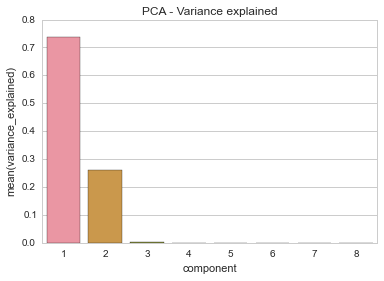

In [38]:
pca_variance_explained_df = pd.DataFrame({
    "component": np.arange(1, components+1),
    "variance_explained": pca.explained_variance_ratio_            
    })

ax = sns.barplot(x='component', y='variance_explained', data=pca_variance_explained_df)
ax.set_title("PCA - Variance explained")
plt.show()

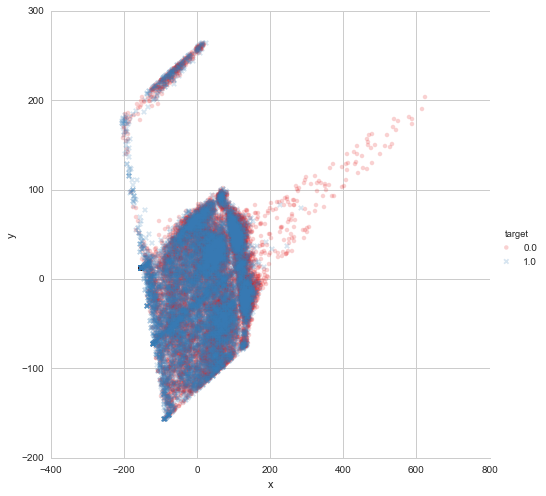

In [39]:
X_pca = pd.DataFrame(pca.transform(X)[:,:2])
X_pca['target'] = y.values
X_pca.columns = ["x", "y", "target"]

sns.lmplot('x','y', 
           data=X_pca, 
           hue="target", 
           fit_reg=False, 
           markers=["o", "x"], 
           palette="Set1", 
           size=7,
           scatter_kws={"alpha": .2}
          )
plt.show()

## Modeling

In [40]:
seed = 7
processors=1
num_folds=3
num_instances=len(X)
scoring='neg_log_loss'

kfold = KFold(n=num_instances, n_folds=num_folds, random_state=seed)

In [41]:
# Prepare some basic models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('K-NN', KNeighborsClassifier(n_neighbors=5)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# models.append(('SVC', SVC(probability=True)))

# Evaluate each model in turn
results = []
names = []

for name, model in models:
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs=processors)
    results.append(cv_results)
    names.append(name)
    print("{0}: ({1:.3f}) +/- ({2:.3f})".format(name, cv_results.mean(), cv_results.std()))

LR: (-0.611) +/- (0.003)


/usr/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: (-0.613) +/- (0.004)
K-NN: (-1.998) +/- (0.011)
CART: (-14.497) +/- (0.255)
NB: (-3.498) +/- (0.239)


In [42]:
num_trees = 100
num_features = 10

model = RandomForestClassifier(n_estimators=num_trees, max_features=num_features)

results = cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

(-0.635) +/- (0.002)


In [43]:
num_trees = 100
num_features = 10

model = ExtraTreesClassifier(n_estimators=num_trees, max_features=num_features)

results = cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

(-0.731) +/- (0.020)


In [44]:
model = AdaBoostClassifier(n_estimators=100, random_state=seed)

results = cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

(-0.690) +/- (0.000)


In [45]:
model = GradientBoostingClassifier(n_estimators=100, random_state=seed)

results = cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))


(-0.609) +/- (0.004)


## Hyper-parameter tuning

In [46]:
lda_grid = GridSearchCV(
    estimator = LinearDiscriminantAnalysis(),
    param_grid = {
        'solver': ['lsqr'],
        'shrinkage': [0, 0.25, 0.5, 0.75, 1],
        'n_components': [None, 2, 5, 10]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

lda_grid.fit(X, y)

print(lda_grid.best_score_)
print(lda_grid.best_params_)

-0.612744764373
{'shrinkage': 0, 'n_components': None, 'solver': 'lsqr'}


In [47]:
knn_grid = GridSearchCV(
    estimator = Pipeline([
        ('min_max_scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]),
    param_grid = {
        'knn__n_neighbors': [25],
        'knn__algorithm': ['ball_tree'],
        'knn__leaf_size': [2, 3, 4],
        'knn__p': [1]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

knn_grid.fit(X, y)

print(knn_grid.best_score_)
print(knn_grid.best_params_)

-0.647550486087
{'knn__leaf_size': 3, 'knn__algorithm': 'ball_tree', 'knn__n_neighbors': 25, 'knn__p': 1}


In [48]:
rf_grid = GridSearchCV(
    estimator = RandomForestClassifier(warm_start=True, random_state=seed),
    param_grid = {
        'n_estimators': [100, 200],
        'criterion': ['gini', 'entropy'],
        'max_features': [18, 20],
        'max_depth': [8, 10],
        'bootstrap': [True]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

rf_grid.fit(X, y)

print(rf_grid.best_score_)
print(rf_grid.best_params_)

-0.60729988462
{'max_features': 18, 'n_estimators': 200, 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10}


In [49]:
ada_grid = GridSearchCV(
    estimator = AdaBoostClassifier(random_state=seed),
    param_grid = {
        'algorithm': ['SAMME', 'SAMME.R'],
        'n_estimators': [10, 25, 50],
        'learning_rate': [1e-3, 1e-2, 1e-1]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

ada_grid.fit(X, y)

print(ada_grid.best_score_)
print(ada_grid.best_params_)

-0.640973140848
{'n_estimators': 10, 'learning_rate': 0.001, 'algorithm': 'SAMME.R'}


In [50]:
gbm_grid = GridSearchCV(
    estimator = GradientBoostingClassifier(warm_start=True, random_state=seed),
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [2, 3, 4],
        'max_features': [10, 15, 20],
        'learning_rate': [1e-1, 1]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

gbm_grid.fit(X, y)

print(gbm_grid.best_score_)
print(gbm_grid.best_params_)

-0.608247203354
{'max_features': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3}


## Final submission

In [51]:
# Create sub models
estimators = []

estimators.append(('lr', LogisticRegression(penalty='l2', C=1)))
estimators.append(('gbm', GradientBoostingClassifier(n_estimators=100,
                                                     max_depth=4,
                                                     learning_rate=0.1,
                                                     max_features=10,
                                                     warm_start=True,
                                                     random_state=seed)))
estimators.append(('rf', RandomForestClassifier(bootstrap=True,
                                                max_depth=8,
                                                n_estimators=200,
                                                max_features=20,
                                                criterion='entropy',
                                                random_state=seed)))
estimators.append(('ada', AdaBoostClassifier(algorithm='SAMME.R',
                                             learning_rate=1e-2,
                                             n_estimators=10,
                                             random_state=seed)))

# create the ensemble model
ensemble = VotingClassifier(estimators, voting='soft', weights=[2,3,3,1])

results = cross_val_score(ensemble, X, y, cv=kfold, scoring=scoring,n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

(-0.608) +/- (0.003)


In [52]:
model = ensemble

model.fit(X, y)
preds = model.predict_proba(data_submit)

submission = pd.DataFrame()
submission["shot_id"] = data_submit.index
submission["shot_made_flag"]= preds[:,1]

submission.to_csv("../output/ensemble.csv",index=False)